In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset, concatenate_datasets
import json
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math
from model import Encoder


/home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameters
hyper_params = {
    "batch_size": 900, # how many independent sequences will we process in parallel?
    "block_size": 400, # what is the maximum context length for predictions?
    # "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "n_embd" : 128, #384
    "n_head" : 4,
    "n_layer" : 6,
    "dropout" : 0.2,
    "vocab_size" : 4
    }
# ------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Encoder(hyper_params)
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

1239554 parameters


In [3]:
batch_size = 1000
p_err_train = 0.1
p_err_val = 0.15

d_list = [5,7,9]
d_max = max(d_list)
d = d_list[0]
mixed_dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_spiral_eos_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_spiral_eos_d_{d}_p_{p_err_val:.2f}.json",
    })
for d in d_list[1:]:
    dataset = load_dataset("json", data_files={
            'train' : f"datasets/train_spiral_eos_d_{d}_p_{p_err_train:.2f}.json",
            'val' : f"datasets/val_spiral_eos_d_{d}_p_{p_err_val:.2f}.json",
        })
    mixed_dataset['train'] = concatenate_datasets([mixed_dataset['train'],dataset['train']])
    mixed_dataset['val'] = concatenate_datasets([mixed_dataset['val'],dataset['val']])

print(mixed_dataset)

pad_token = 3.0
def collate_fn(examples):
    target = [example['target'] for example in examples]
    dist = [example['dist'] for example in examples]
    input = []
    attn_mask = []
    for idx, example in enumerate(examples):
        input.append(example['input'] + [pad_token]*((d_max+1)**2 - (dist[idx]+1)**2))
        attn_mask.append( [1.0]*((dist[idx]+1)**2+2) + [0.0]*((d_max+1)**2 - (dist[idx]+1)**2))
    return {'input': input, 'target': target, 'dist': dist, 'attn_mask': attn_mask}

data_loader = DataLoader(mixed_dataset['train'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)
data_loader_val = DataLoader(mixed_dataset['val'], batch_size=batch_size, collate_fn=collate_fn, shuffle = True)


DatasetDict({
    train: Dataset({
        features: ['dist', 'errors', 'input', 'target'],
        num_rows: 600000
    })
    val: Dataset({
        features: ['dist', 'errors', 'input', 'target'],
        num_rows: 30000
    })
})


In [4]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, _ = model(X, attn_mask)
        pred = (err_probs > 0.5).to(Y)
        # print(err_probs.shape, Y.shape)
        acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [5]:
learning_rate = 5e-4
learning_rate_min = 0
eval_interval = 100
eval_iters =  10
num_epochs = 100

# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
cos_lr = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=learning_rate_min)


loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    
    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # # if i_b>= eval_iters:
        # #     break
        # # # every once in a while evaluate the loss on train and val sets
        # # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        attn_mask = torch.tensor(batch['attn_mask']).to(device, dtype= torch.float32)
        Y = torch.tensor(batch['target']).to(device)
        _, loss = model(X, attn_mask, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1
        
    cos_lr.step()



epoch, step (0, 0): train loss 1.3864, val loss 1.3863, val acc 0.5008
epoch, step (0, 100): train loss 1.0912, val loss 1.2450, val acc 0.6194
epoch, step (0, 200): train loss 1.0582, val loss 1.2360, val acc 0.6199
epoch, step (0, 300): train loss 1.0561, val loss 1.2337, val acc 0.6221
epoch, step (0, 400): train loss 1.0512, val loss 1.2411, val acc 0.6155
epoch, step (0, 500): train loss 1.0369, val loss 1.2287, val acc 0.6244
epoch, step (1, 0): train loss 1.0380, val loss 1.2352, val acc 0.6266
epoch, step (1, 100): train loss 0.8918, val loss 1.1512, val acc 0.6739
epoch, step (1, 200): train loss 0.7992, val loss 1.0912, val acc 0.7055
epoch, step (1, 300): train loss 0.7457, val loss 1.0894, val acc 0.7144
epoch, step (1, 400): train loss 0.6957, val loss 1.0181, val acc 0.7220
epoch, step (1, 500): train loss 0.6322, val loss 0.9866, val acc 0.7380
epoch, step (2, 0): train loss 0.6358, val loss 0.9720, val acc 0.7456
epoch, step (2, 100): train loss 0.5780, val loss 0.9507,

KeyboardInterrupt: 

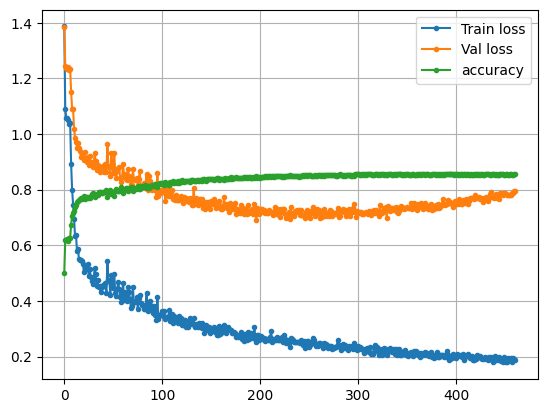

In [6]:
plt.plot(loss_train,".-",label="Train loss")
plt.plot(loss_val,".-",label="Val loss")
plt.plot(acc_val,".-",label="accuracy")
# plt.xlim([0,250])
# plt.ylim([0,1])
plt.grid()
plt.legend()


In [15]:
# PATH = f"models/enc_pad_eos_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
d_list = [5,7,9]
PATH = f"model_params/lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"
print(PATH)
# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
    "epoch": epoch,
    "model_hyperparams": hyper_params,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict(),
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

model_params/lr_0.0005_d_5_9.pt


In [17]:
# # hyperparameters
# hyper_params = {
#     "batch_size": 900, # how many independent sequences will we process in parallel?
#     "block_size": 400, # what is the maximum context length for predictions?
#     # "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
#     "n_embd" : 128, #384
#     "n_head" : 4,
#     "n_layer" : 6,
#     "dropout" : 0.2,
#     "vocab_size" : 4
#     }
# # ------------

learning_rate = 5e-4
FILE = f"model_params/lr_{learning_rate:.4f}_d_{min(d_list)}_{max(d_list)}.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model = Encoder(checkpoint['model_hyperparams'])
optimizer = torch.optim.AdamW(model.parameters(), lr=0)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

Encoder(
  (token_embdding_table): Embedding(4, 128)
  (position_embdding_table): Embedding(400, 128)
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  

In [53]:
def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}


batch_size = 1000
# p_err_list = torch.arange(0.01,0.31,0.01)
p_err_list =  np.arange(0.008,0.21,0.008) # 
d_list = torch.arange(5,12,2)
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                # 'test' : f"../qec-data/datasets/test_spiral_eos_d_{d}_p_{p_err:.2f}.json",
                'test' : f"datasets/test_spiral_eos_d_{d}_p_{p_err:.3f}.json",
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                # acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
                acc[i_p,i_d] += torch.sum(torch.prod(pred == Y, dim=1)).item()/Y.shape[0]
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 677.48it/s]
Generating test split: 100000 examples [00:00, 663050.35 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 626.86it/s]
Generating test split: 100000 examples [00:00, 673405.15 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 605.50it/s]
Generating test split: 20000 examples [00:00, 476744.64 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1113.73it/s]
Generating test split: 100000 examples [00:00, 687199.90 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 632.43it/s]
Generating test split: 20000 examples [00:00, 426718.76 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1047.27it/s]
Generating test split: 100000 examples [00:00, 745449.96 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1170.29it/s]
Generating test split: 20000 examples [00:00, 449743.08 examples/s]
Extracting data files: 100%

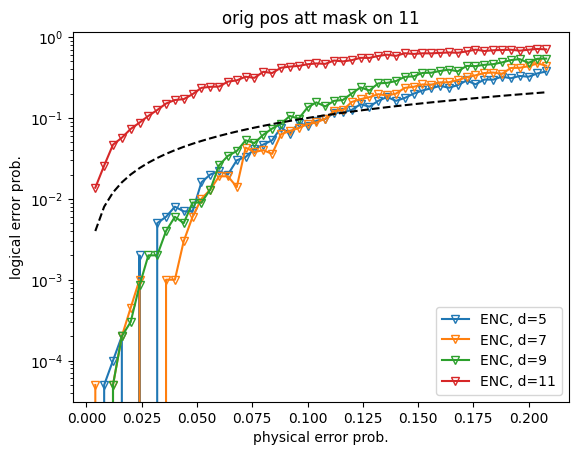

In [52]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    # p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    # plt.plot(p_err_list,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],"v-", color= f"C{i_d}",markerfacecolor="None",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.title(f"orig pos att mask on {max(d_list)}")
# plt.ylim([-0.02,0.47])
plt.yscale("log")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
